# Customer Churn Project — Part 3: Logistic Regression Classifier (Baseline Model)

This notebook is the starting point for the Customer Churn Analysis Project. Its primary goals are to ingest, explore, clean, and augment the customer activity logs to build a robust dataset for understanding user behavior and churn.

Specifically, in this notebook, I:
1. Conduct exploratory data analysis (EDA) to compare active vs. churned users across engagement metrics.
2. Examine event distributions, feature correlations, and behavioral indicators leading to churn.
3. Analyze temporal and geographic churn trends to understand how churn varies across months and states.
4. Identify early behavioral signals (e.g., low activity, fewer playlists, short active periods) that differentiate churned users.
5. Prepare analytical insights to inform predictive modeling and feature selection in the next stage (03_Modeling.ipynb).

The focus of this notebook is on uncovering data-driven insights about customer retention and disengagement, laying the foundation for building a churn prediction model and actionable business recommendations.

In [7]:
import json
import pandas as pd
import numpy as np
import os
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from sklearn.metrics import roc_curve, auc



sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [2]:
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/openjdk-17.jdk/Contents/Home"

try:
    spark.stop()
except:
    pass


spark = (
    SparkSession.builder
    .appName("CustomerChurn_EDA")
    .master("local[*]")
    .config("spark.driver.memory", "6g")  
    .config("spark.sql.shuffle.partitions", "8")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")
#print("✅ Spark started:", spark.version)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/14 13:06:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/14 13:06:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/14 13:06:40 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
data = spark.read.parquet("../data/churn_data_ready.parquet")

In [4]:
user_features = (
    data.groupBy("userId")
    .agg(
        F.first("churn_flag").alias("churn_flag"),
        F.countDistinct("sessionId").alias("num_sessions"),
        F.sum(F.when(F.col("page") == "NextSong", 1).otherwise(0)).alias("num_songs"),
        F.sum(F.when(F.col("page") == "Thumbs Up", 1).otherwise(0)).alias("thumbs_up"),
        F.sum(F.when(F.col("page") == "Thumbs Down", 1).otherwise(0)).alias("thumbs_down"),
        F.sum(F.when(F.col("page") == "Add to Playlist", 1).otherwise(0)).alias("add_playlist"),
        ( (F.max("ts") - F.min("ts")) / (1000 * 60 * 60 * 24) ).alias("active_days")
    )
)

In [15]:
user_features.head(10)

[Row(userId='1567623', churn_flag=0, num_sessions=16, num_songs=1135, thumbs_up=65, thumbs_down=15, add_playlist=39, active_days=55.644050925925924),
 Row(userId='1396135', churn_flag=0, num_sessions=9, num_songs=974, thumbs_up=49, thumbs_down=9, add_playlist=21, active_days=52.782233796296296),
 Row(userId='1444744', churn_flag=1, num_sessions=21, num_songs=1406, thumbs_up=63, thumbs_down=15, add_playlist=53, active_days=57.14454861111111),
 Row(userId='1082354', churn_flag=0, num_sessions=13, num_songs=442, thumbs_up=19, thumbs_down=7, add_playlist=10, active_days=53.66190972222222),
 Row(userId='1633767', churn_flag=0, num_sessions=29, num_songs=2853, thumbs_up=138, thumbs_down=29, add_playlist=88, active_days=50.004502314814815),
 Row(userId='1187490', churn_flag=0, num_sessions=21, num_songs=1963, thumbs_up=95, thumbs_down=22, add_playlist=62, active_days=58.980358796296294),
 Row(userId='1180483', churn_flag=0, num_sessions=6, num_songs=168, thumbs_up=13, thumbs_down=1, add_playl

In [10]:
user_features.count()

22261

### I. Baseline Logistic Model

In [5]:
# Feature columns
feature_cols = ["num_sessions", "num_songs", "thumbs_up", "thumbs_down", "add_playlist", "active_days"]

# Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Initialize logistic regression
lr = LogisticRegression(labelCol="churn_flag", featuresCol="features")

# Build pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Train/test split
train_df, test_df = user_features.randomSplit([0.7, 0.3], seed=42)

# Fit model
lr_model = pipeline.fit(train_df)

# Evaluate
predictions = lr_model.transform(test_df)
evaluator = BinaryClassificationEvaluator(labelCol="churn_flag", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"ROC-AUC (Baseline Logistic Regression): {roc_auc:.3f}")

ROC-AUC (Baseline Logistic Regression): 0.855


AUC-ROC (Area Under the Receiver Operating Characteristic Curve) shows how well the model can distinguish between churned and active users. The ROC-AUC = 0.855 means the model performs very well, it can correctly rank most users by their churn risk. 


So, for example, if we randomly select one churned user and one active user, there’s an ~85% chance the model will assign a higher churn probability to the churned user. This means features like num_sessions, thumbs_up, active_days, etc., are already quite informative — even without advanced models.

In [6]:
coefficients = lr_model.stages[-1].coefficients
intercept = lr_model.stages[-1].intercept
coef_df = pd.DataFrame({"feature": feature_cols, "coefficient": coefficients})
coef_df.sort_values("coefficient", ascending=False)

,feature,coefficient
0,num_sessions,0.050649
3,thumbs_down,0.038612
1,num_songs,0.000414
4,add_playlist,-0.000337
2,thumbs_up,-0.013491
5,active_days,-0.081934


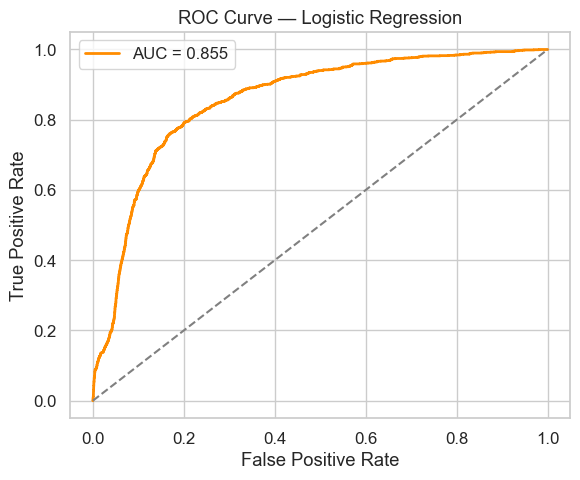

In [8]:
pdf = predictions.select("churn_flag", "probability").toPandas()
pdf["prob_churn"] = pdf["probability"].apply(lambda x: float(x[1]))

fpr, tpr, _ = roc_curve(pdf["churn_flag"], pdf["prob_churn"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color="gray", linestyle="--")
plt.title("ROC Curve — Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

Together, the AUC score and the model coefficients suggest that the logistic regression model is highly effective at identifying churners based on a small set of behavioral features. The model doesn’t just rely on how much users engage, but rather on the quality of that engagement. For example, users who give more thumbs up or have more active days are less likely to churn, indicating that positive interaction and frequent activity are strong signals of retention. 

On the other hand, features like thumbs down are clear indicators of dissatisfaction and are positively associated with churn. Interestingly, even though features like the total number of songs played or sessions completed might suggest higher engagement, they don’t necessarily reduce churn and in some cases may slightly increase it — possibly capturing “last attempts” before a user leaves. Overall, these behavioral signals can be used to predict churn early and guide proactive interventions to improve user retention.